In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from collections import Counter
from plotly import express as ex

%matplotlib inline

In [193]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd

from glob import glob
from os import path
from tqdm.cli import tqdm

In [203]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,Callback

In [194]:
PATH = path.abspath("../datasets/BCCD/")
IMG_SIZE = 384

In [172]:
data = []
for p in glob(path.abspath(f"{PATH}/annotations/*.xml")):
    try:
        parse = ET.parse(p)
    except:
        continue
    objects = [[i.tag,i.text] for i in parse.iter()]
    image = {i:j for i ,j in objects[:11]}
    boxes = []
    for ob,name,pose,_,__,___,xmin,ymin,xmax,ymax in np.array(objects[11:]).reshape(-1,20)[:,1::2]:
        boxes.append(dict(
            name=name,
            xmin=int(IMG_SIZE*int(xmin)/int(image['width'])),
            ymin=int(IMG_SIZE*int(ymin)/int(image['height'])),
            xmax=int(IMG_SIZE*int(xmax)/int(image['width'])),
            ymax=int(IMG_SIZE*int(ymax)/int(image['height'])),
        ))    
    image['boxes'] = boxes
    image['filename'] = path.abspath(f"{PATH}/images/{image['filename']}")
    [image.pop(i) for i in ['annotation','path','folder','source','size','database','segmented','depth']];
    data.append(image)

In [336]:
data[2]

{'filename': '/storage/detect/datasets/BCCD/images/BloodImage_00069.jpg',
 'width': '640',
 'height': '480',
 'boxes': [{'name': 'RBC', 'xmin': 10, 'ymin': 188, 'xmax': 68, 'ymax': 268},
  {'name': 'RBC', 'xmin': 126, 'ymin': 217, 'xmax': 184, 'ymax': 297},
  {'name': 'RBC', 'xmin': 195, 'ymin': 107, 'xmax': 267, 'ymax': 190},
  {'name': 'RBC', 'xmin': 162, 'ymin': 45, 'xmax': 228, 'ymax': 126},
  {'name': 'RBC', 'xmin': 96, 'ymin': 0, 'xmax': 169, 'ymax': 68},
  {'name': 'RBC', 'xmin': 114, 'ymin': 122, 'xmax': 178, 'ymax': 202},
  {'name': 'RBC', 'xmin': 256, 'ymin': 303, 'xmax': 321, 'ymax': 384},
  {'name': 'RBC', 'xmin': 286, 'ymin': 156, 'xmax': 351, 'ymax': 237},
  {'name': 'RBC', 'xmin': 292, 'ymin': 12, 'xmax': 345, 'ymax': 78},
  {'name': 'RBC', 'xmin': 315, 'ymin': 97, 'xmax': 367, 'ymax': 163},
  {'name': 'RBC', 'xmin': 0, 'ymin': 256, 'xmax': 69, 'ymax': 351},
  {'name': 'RBC', 'xmin': 66, 'ymin': 246, 'xmax': 135, 'ymax': 324},
  {'name': 'WBC', 'xmin': 204, 'ymin': 208, 

In [175]:
images = np.array([cv2.resize(cv2.imread(i['filename']),(IMG_SIZE,IMG_SIZE)) for i in data])

In [176]:
class JSON(object):
    """
    Helper Class For Mapping JSON vars to Objects
    """
    def __init__(self,data=dict(),inner=False):
        for key in data:
            if type(data[key]) == dict:
                self.__dict__[key] = JSON(data[key],inner=True)
            else:
                self.__dict__[key] = data[key]

    def __repr__(self):
        return self.__dict__.__str__()
    
    def __str__(self):
        return self.__dict__.__str__()
    
    def __getitem__(self,key):
        return self.__dict__[key]
    
    def __setitem__(self,key,value):
        self.__dict__[key] = value
    
    def __iter__(self):
        for key in self.__dict__:
            if type(self.__dict__[key]) == JSON:
                yield key, self.__dict__[key]()
            else:
                yield key, self.__dict__[key]
        
    def __call__(self,):
        return {i:j for i,j in  self.__iter__()}
    
class BoxGrid(object):
    """
    Encodes Box
    """
    def __init__(self,low,high):
        self.low = low
        self.high = high
        self.repr = f"""
BoxGrid(
    low={self.low},
    high={self.high}
)
        """
    
    def __repr__(self):
        return self.repr
    
    def encode(self,h,w):
        return h/self.high,w/self.high
    
    def get_pair(self,y,x,h,w):
        h = int(h*self.high)
        w = int(w*self.high)
        return (x - (h//2),y - (h//2)),(x + (h//2),y + (h//2))
    
    def decode(self,):
        pass
    
    def encodeBatch(self,):
        pass
    
    def decodeBatch(self,):
        pass

In [524]:
class AnchorGrid(object):
    
    def __init__(self,resize_factor,k,image_size,box_gen,classes,n_classes):
        
        self.k = k
        self.classes = classes
        self.n_classes = n_classes
        self.resize_factor = resize_factor
        self.image_size = image_size
        self.grid_size = image_size // resize_factor
        self.box_gen = BoxGrid(**box_gen)
        self.length = self.grid_size*self.grid_size*self.k
        self.class_prob = np.zeros((self.n_classes+1))
        
        
        self.repr = f"""
AnchorGrid (
    resize_factor={self.resize_factor},
    k={self.k},
    image_size={self.image_size},
    grid_size={self.grid_size}
)"""
        self.ignored = []
        
    def __repr__(self,):
        return self.repr
                
    def __call__(self,data):
        """
        Returns : encoded_prob,encoded_box
        """
        box = np.zeros((self.grid_size,self.grid_size,self.k,4))
        prob_0 = np.zeros((self.grid_size,self.grid_size,self.k,self.n_classes))
        prob_1 = np.ones((self.grid_size,self.grid_size,self.k,1))
        prob = np.concatenate((prob_1,prob_0),axis=3)        
        
        data = data[np.logical_and(np.all(data[:,3:] <= self.box_gen.high,axis=1), np.any(data[:,3:] > self.box_gen.low,axis=1))]
        _counter = Counter()

        for cls,y,x,h,w in data:
            Ox = int(x // self.resize_factor) 
            Oy = int(y // self.resize_factor) 
            if Ox >= self.grid_size or Oy >= self.grid_size:
                continue

            x = (x - (Ox*self.resize_factor)) / self.resize_factor
            y = (y - (Oy*self.resize_factor)) / self.resize_factor
            h,w = self.box_gen.encode(h,w)
            Oi = _counter[f"{Oy}x{Ox}"]
            
            if Oi >= self.k:
                self.ignored.append(data)
                continue
            
            class_prob = self.class_prob.copy()
            class_prob[self.classes.index(cls)+1] = 1
            box[Oy,Ox,Oi,:] = [y,x,h,w]
            prob[Oy,Ox,Oi,:] = class_prob
            
            _counter[f"{Oy}x{Ox}"] += 1

        prob,box =  prob.reshape(-1,self.k,self.n_classes+1),box.reshape(-1,self.k,4)
        return prob.reshape(-1,self.n_classes+1),box.reshape(-1,4)
    
    def encode(self,data):
        return self.__call__(data)
    
    def decode(self,prob,boxes,thresh=0.9):
        prob = prob.reshape(-1,self.k,self.n_classes+1).reshape(self.grid_size,self.grid_size,self.k,self.n_classes+1).copy()
        boxes = boxes.reshape(-1,self.k,4).reshape(self.grid_size,self.grid_size,self.k,4).copy() 
        boxes[:,:,:,:2] = ((boxes[:,:,:,:2] * self.resize_factor) + self.grid_decode).astype(int) - (self.resize_factor // 2)
        
        prob = prob.reshape(-1,4)
        classes = prob.argmax(axis=-1)
        mask = classes > 0
        
        scores = prob.max(axis=-1)[mask]
        boxes = boxes.reshape(-1,4)[mask]
        classes = classes[mask]
        
        boxes[:,2:] = boxes[:,2:] * self.box_gen.high
        return classes.astype(int),scores.astype(float),boxes.astype(int)
        
    def generate(self,ret=False):
        xx,yy = np.meshgrid(np.arange(self.grid_size),np.arange(self.grid_size))
        xx,yy = np.reshape(xx,(self.grid_size,self.grid_size,1)),np.reshape(yy,(self.grid_size,self.grid_size,1))
        self.reference = np.concatenate((yy,xx),axis=-1)
        self.grid = self.reference.copy() * self.resize_factor
        self.grid += self.resize_factor // 2
        self.grid_decode = self.grid.copy().reshape(self.grid_size,self.grid_size,1,2).repeat(self.k,axis=2)
        if ret:
            return self.grid.copy(),self.reference.copy()

    def plot_grid(self,img,axes,prob,boxes):
        prob = prob.reshape(-1,self.k,self.n_classes+1).reshape(self.grid_size,self.grid_size,self.k,self.n_classes+1).copy()
        boxes = boxes.reshape(-1,self.k,4).reshape(self.grid_size,self.grid_size,self.k,4).copy()
        boxes[:,:,:,:2] = ((boxes[:,:,:,:2] * self.resize_factor) + self.grid_decode).astype(int) - (self.resize_factor // 2)
        
        for ba,pa,(y,x) in zip(boxes.reshape(-1,self.k,4),prob.reshape(-1,self.k,self.n_classes+1),self.grid.reshape(-1,2)):
            img = cv2.circle(img,(x,y),2,(255,255,0),-1)
            img = cv2.rectangle(
                        img,
                        (x-(self.resize_factor//2),y-(self.resize_factor//2)),
                        (x+(self.resize_factor//2),y+(self.resize_factor//2)),
                        (255,255,0),
                        1
                    )
            for (y,x,h,w),p in zip(ba,pa):
                p_ = p.argmax()
                if p_ > 0:
                    xmin = int(x - (w*self.box_gen.high//2))
                    ymin = int(y - (h*self.box_gen.high//2))
                    xmax = int(x + (w*self.box_gen.high//2))
                    ymax = int(y + (h*self.box_gen.high//2))
                    img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),1)
                    img = cv2.putText(
                            img,
                            self.classes[p.argmax()-1],
                            (xmin+3,ymin+8),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.3,
                            (250,250,250)
                        )
            
        axes.imshow(img)

In [541]:
class Anchors(object):
    """
    Encode Various Sizes Of FPNS
    """
    
    def __init__(self,img_size,classes,config,):
        self.img_size = img_size
        self.config = config
        self.classes = classes
        self.n_classes = len(classes)
        
        for cfg in config:
            self.__dict__[f"ANCHOR_{cfg['name']}"] = AnchorGrid(**cfg.anchor_grid(),classes=classes,n_classes=self.n_classes)
            self.__dict__[f"ANCHOR_{cfg['name']}"].generate()
        
        self.ANCHORS = [i for (i,j) in self.__dict__.items() if "ANCHOR_" in i]
        
        self.skipped = []
        
    def __repr__(self,):
        return self.config.__repr__()
    
    def __call__(self,data:dict,conc:bool=True):
        """
        Returns : encoded_prob,encoded_box
        """
        boxt = pd.DataFrame(data)
        boxt['h'] = boxt.ymax - boxt.ymin
        boxt['w'] = boxt.xmax - boxt.xmin

        boxt['y'] = boxt.ymin + ( boxt.h // 2 )
        boxt['x'] = boxt.xmin + ( boxt.w // 2 )
        
        boxt = boxt[['name','y','x','h','w']].sort_values(by=['y','x','h','w']).values
        prob,box = [],[]
        
        for anchor in self.ANCHORS:
            p,b = self.__dict__[anchor](boxt)
            prob.append(p)
            box.append(b)
            
        if conc:
            prob = np.concatenate(prob,axis=0)
            box = np.concatenate(box,axis=0)
            return prob,box
        
        return prob,box
    
    def encode(self,data,conc:bool=True):
        return self.__call__(data,conc=conc)
    
    def encode_batch(self,data,bar=False,conc:bool=True):
        prob,boxes = [],[]
        for i,d in enumerate(tqdm(data) if bar else data):
            p,b = self.__call__(d['boxes'],conc=conc)
            prob.append(p)
            boxes.append(b)                
        return np.array(prob),np.array(boxes)
    
    def decode(self,prob,boxes,thresh=0.9):
        """
        Returns Classes,Scores,Boxes
        """
        prob = prob.reshape(-1,self.n_classes + 1)
        boxes = boxes.reshape(-1,4)
        
        last = 0
        ret_boxes = []
        ret_scores = []
        ret_classes = []
        for anchor in self.ANCHORS:
            index = self.__dict__[anchor].length
            batch_ = (prob[last:last+index].copy(),boxes[last:last+index].copy())
            C,S,B = self.__dict__[anchor].decode(*batch_,thresh=thresh)
            last = last+index
            ret_scores.append(S)
            ret_boxes.append(B)
            ret_classes.append(C)
                       
        return (
                np.concatenate(ret_classes,axis=0).astype(np.int32),
                np.concatenate(ret_scores,axis=0).astype(np.float32),
                np.concatenate(ret_boxes,axis=0).astype(np.int32)
               )

    def plot_grid(self,img,prob,boxes):
        img = cv2.resize(img.copy(),(self.img_size,self.img_size))
        fig,axes = plt.subplots(len(self.ANCHORS),1,figsize=(14,14*len(self.ANCHORS)))
                
        prob = prob.reshape(-1,self.n_classes+1)
        boxes = boxes.reshape(-1,4)
        
        last = 0
        for anchor,ax in zip(self.ANCHORS,axes):
            index = self.__dict__[anchor].length
            batch = (prob[last:last+index].copy(),boxes[last:last+index].copy())
            self.__dict__[anchor].plot_grid(img.copy(),ax,*batch)
            last = last+index

In [680]:
anchor_config = JSON({
    "img_size":IMG_SIZE,
    "classes":['RBC','WBC','Platelets'],
    "config":[
        JSON({
                'anchor_grid': {
                    'resize_factor': 32, 
                    'k': 6, 
                    'image_size': IMG_SIZE, 
                    'box_gen': {
                        'low': 2, 
                        'high': 224
                    }
                }, 
            'name': 'FPN'
        }),
    ]
})

In [681]:
anchors = Anchors(**anchor_config())

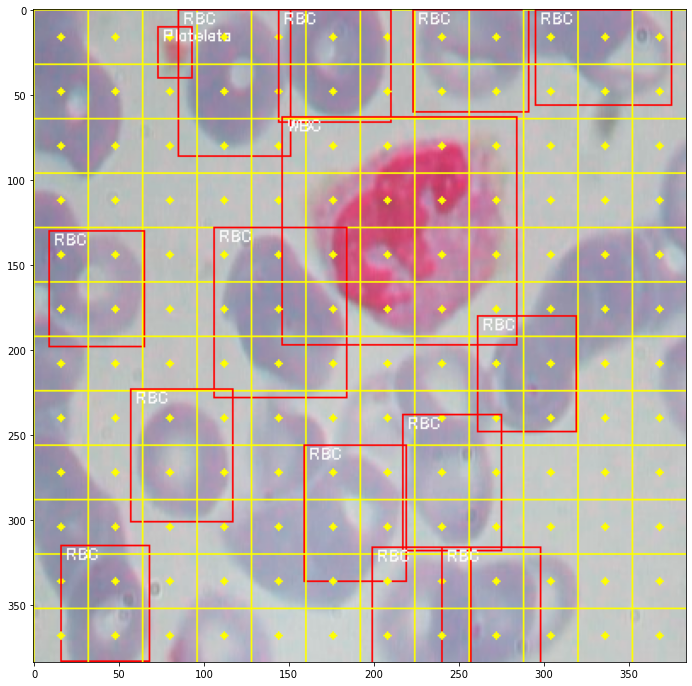

In [682]:
i = np.random.randint(0,len(images))
img = images[i].copy()

fig,axes = plt.subplots(1,1,figsize=(12,12))
p,b = anchors.encode(data[i]['boxes'])
anchors.ANCHOR_FPN.plot_grid(img,axes,p,b)

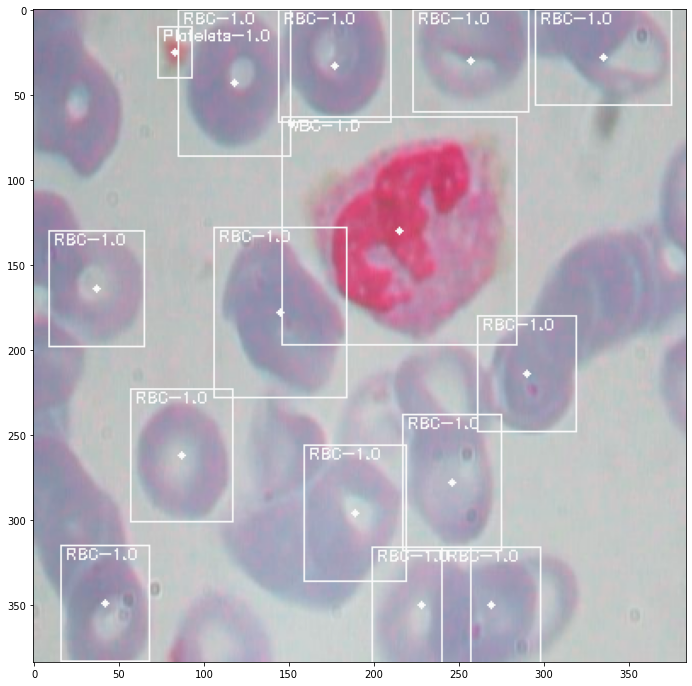

In [683]:
img = images[i].copy()
classes,scores,boxes = anchors.decode(p,b)

for C,S,(y,x,h,w) in zip(classes,scores,boxes):
    xmin = x - (w//2)
    ymin = y - (h//2)
    xmax = x + (w//2)
    ymax = y + (h//2)
    
    img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(250,250,250),1)
    img = cv2.circle(img,(x,y),2,(250,250,250),-1)
    img = cv2.putText(
                        img,
                        f"{anchors.classes[C-1]}-{S}",
                        (xmin+3,ymin+8),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.3,
                        (250,250,250)
                    )
    
plt.figure(figsize=(12,12))
plt.imshow(img)

In [684]:
y_prob,y_box = anchors.encode_batch(data,bar=True)

100%|██████████| 363/363 [00:04<00:00, 87.03it/s]


In [685]:
def proposals(_in,ksize,k,name):
    prob = Conv2D(k*4,ksize,padding="same",name=f"prob_conv_{name}",kernel_initializer="ones",use_bias=False)(_in)
    prob = BatchNormalization(name=f"prob_norm_{name}")(prob)
    prob = Activation("sigmoid",name=f"prob_out_{name}")(prob)
    prob = Reshape((-1,4),name=f"{name}_prob")(prob)

    box = Conv2D(k*4,ksize,padding="same",name=f"box_conv_{name}",kernel_initializer="ones",use_bias=False)(_in)
    box = BatchNormalization(name=f"box_batch_{name}")(box)
    box = Activation("sigmoid",name=f"box_out_{name}")(box)
    box = Reshape((-1,4),name=f"{name}_box")(box)
    
    return prob,box

def mob_block(x,num_filters,strides):
    x = DepthwiseConv2D(kernel_size=3 , padding='same' )( x )
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters,3 ,use_bias=False ,padding='same')( x )
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,1 ,use_bias=False ,strides=strides,padding='same')( x )
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

_in = keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
net = keras.applications.MobileNet(include_top=False,input_tensor=_in,weights="imagenet")

feat = net.output
feat = Dense(1024)(feat)
feat = LeakyReLU(0.1)(feat)
prob,box = proposals(feat,1,6,"p")

model = keras.Model(_in,[prob,box])

In [686]:
# model.summary()

In [687]:
%%time
a = model(images[0:1])

CPU times: user 41 ms, sys: 0 ns, total: 41 ms
Wall time: 40.2 ms


In [688]:
a[0].shape,y_prob[0].shape

(TensorShape([1, 864, 4]), (864, 4))

In [689]:
class BoxLoss(tf.Module):
    """
    BoxLoss
    """
    def __init__(self,):
        self.__name__="BoxLoss"
        self.zero = tf.constant(0,tf.float32)
        self.one = tf.constant(1,tf.float32)
        self.two = tf.constant(2,tf.float32)
        self.l2_loss = tf.keras.losses.MeanSquaredError()
        self.l1_loss = tf.keras.losses.MeanAbsoluteError()

        self.slice_y = {"begin":[0,0,0],"size":[-1,-1,1]}
        self.slice_x = {"begin":[0,0,1],"size":[-1,-1,1]}
        self.slice_h = {"begin":[0,0,2],"size":[-1,-1,1]}
        self.slice_w = {"begin":[0,0,3],"size":[-1,-1,1]}
        
        self.repr = f"""BoxLoss()"""
        
    def __repr__(self,):
        return self.repr

    
    @tf.function
    def __call__(self,y_true,y_pred,*args,**kwargs):
        
        y = tf.slice(y_true,**self.slice_y)
        x = tf.slice(y_true,**self.slice_x)

        mask = tf.logical_or(tf.greater(y,self.zero),tf.greater(x,self.zero))

        y = y[mask] 
        x = x[mask] 
        h = tf.slice(y_true,**self.slice_h)[mask] 
        w = tf.slice(y_true,**self.slice_w)[mask] 

        y_ = tf.slice(y_pred,**self.slice_y)[mask] 
        x_ = tf.slice(y_pred,**self.slice_x)[mask] 
        h_ = tf.slice(y_pred,**self.slice_h)[mask] 
        w_ = tf.slice(y_pred,**self.slice_w)[mask] 
        
        loss = self.l2_loss(x,x_) + self.l2_loss(y,y_) + self.l1_loss(h,h_) + self.l1_loss(w,w_)
        
        if tf.math.is_nan(loss):
            return self.zero
        
        return loss

In [690]:
def get_split(length , test ):
    train_index = np.arange(0,length)
    test_index = set(np.arange(1,length,length//test)[:test])
    train_index = set(train_index)    
    train_index = list(train_index.difference(test_index))
    test_index = list(test_index)
    
    return train_index,test_index

def flow(epochs:int,x:list,y:tuple,index:list,batch_size:int):
    images = x
    y_prob,y_boxes = y
    index = np.array(index)
    for epoch in range(epochs):
        index = index.reshape(-1)
        np.random.shuffle(index)
        index = index.reshape(-1,batch_size)
        for i in index:
            yield images[i] ,(y_prob[i],y_boxes[i])
            
            
def get_split(length:int,test_size):
    test = test_size if isinstance(length,int) else int(test_size*length)
    train_index = np.arange(0,length)
    test_index = set(np.random.choice(train_index,test,replace=False))
    train_index = set(train_index)    
    train_index = list(train_index.difference(test_index))
    test_index = list(test_index)

    return train_index,test_index

In [691]:
loss = BoxLoss()
opt = keras.optimizers.Nadam(learning_rate=0.001-0.00001,beta_1=0.9,beta_2=0.997,epsilon=1e-8)

model.compile(optimizer=opt,loss={
    "p_prob":tf.losses.BinaryCrossentropy(),
    "p_box":loss,
})

In [692]:
T,t = get_split(len(images),len(images)%32)

In [711]:
BATCH_SIZE = 4
EPOCHS  = 20
f = flow(EPOCHS,images,(y_prob,y_box),T,BATCH_SIZE)

In [704]:
chk = ModelCheckpoint(filepath="../checkpoints/BCCD_mobilnet",save_weights_only=True,monitor='loss')

In [712]:
model.fit_generator(f,steps_per_epoch=len(T)//BATCH_SIZE,epochs=EPOCHS,callbacks=[chk])

Epoch 1/20
88/88 [==============================] - 7s 84ms/step - loss: 0.1019 - p_prob_loss: 0.0769 - p_box_loss: 0.0251
Epoch 2/20
88/88 [==============================] - 8s 86ms/step - loss: 0.0965 - p_prob_loss: 0.0723 - p_box_loss: 0.0243
Epoch 3/20
88/88 [==============================] - 7s 85ms/step - loss: 0.0912 - p_prob_loss: 0.0677 - p_box_loss: 0.0235
Epoch 4/20
88/88 [==============================] - 7s 84ms/step - loss: 0.0865 - p_prob_loss: 0.0635 - p_box_loss: 0.0230
Epoch 5/20
88/88 [==============================] - 7s 84ms/step - loss: 0.0823 - p_prob_loss: 0.0597 - p_box_loss: 0.0226
Epoch 6/20
88/88 [==============================] - 8s 85ms/step - loss: 0.0776 - p_prob_loss: 0.0559 - p_box_loss: 0.0217
Epoch 7/20
88/88 [==============================] - 7s 84ms/step - loss: 0.0741 - p_prob_loss: 0.0526 - p_box_loss: 0.0215
Epoch 8/20
88/88 [==============================] - 7s 83ms/step - loss: 0.0715 - p_prob_loss: 0.0495 - p_box_loss: 0.0220
Epoch 9/20
88/88

In [721]:
def IoU(y,x,h,w,box):
    dist = np.sqrt(np.square(y - box[:,0]) + np.square(x - box[:,1]))
    closest = dist.argsort()[1]
    y_,x_,h_,w_ = boxes[closest].copy()
    xmin = x - (w//2)
    ymin = y - (h//2)
    xmax = x + (w//2)
    ymax = y + (h//2)
    xmin_ = x_ - (w_//2)
    ymin_ = y_ - (h_//2)
    xmax_ = x_ + (w_//2)
    ymax_ = y_ + (h_//2)

    Ch = min(ymax,ymax_) - max(ymin,ymin_)
    Cw = min(xmax,xmax_) - max(xmin,xmin_)

    Aa = h  * w
    Ba = h_ * w_
    Ca = Ch * Cw
    IoU = (Ca)/(Aa + Ba - Ca)
    return IoU,closest,dist[closest]

def suppress(classes,scores,boxes,thresh=0.45):
    skip = []
    newboxes = []
    newscores = []
    newclasses = []
    for j,(s,c,(y,x,h,w)) in enumerate(zip(scores,classes,boxes)):
        if j not in skip:
            iou,cls,dist = IoU(y,x,h,w,boxes.copy())
            if iou > thresh:
                skip.append(cls)
            newboxes.append([y,x,h,w])
            newscores.append(s)
            newclasses.append(c)
            
    return np.array(newclasses),np.array(newscores),np.array(newboxes)

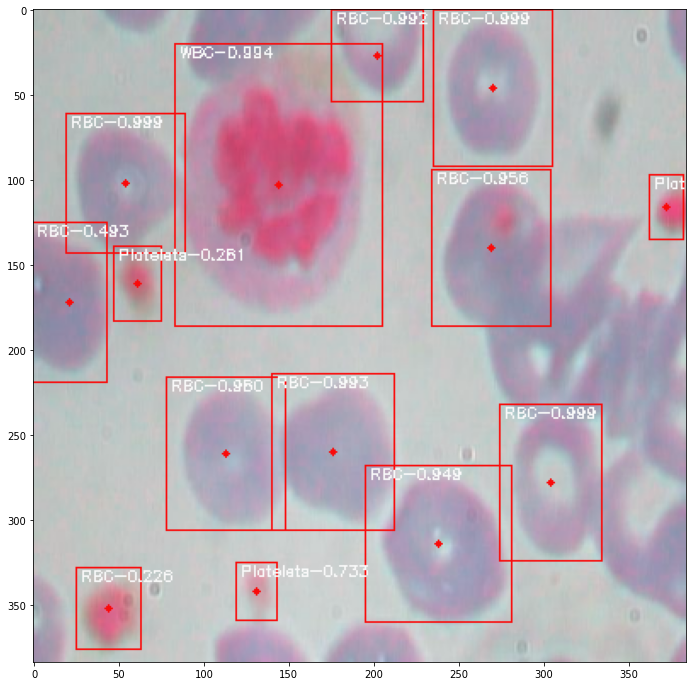

In [738]:
i = np.random.choice(T)
img = images[i].copy()
p,b = model.predict(np.expand_dims(img,0))
classes,scores,boxes = anchors.decode(p,b)
classes,scores,boxes = suppress(classes,scores,boxes)

for C,S,(y,x,h,w) in zip(classes,scores,boxes):
    xmin = x - (w//2)
    ymin = y - (h//2)
    xmax = x + (w//2)
    ymax = y + (h//2)    
    img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(250,10,10),1)
    img = cv2.circle(img,(x,y),2,(250,10,10),-1)
    img = cv2.putText(
                        img,
                        f"{anchors.classes[C-1]}-{str(S)[:5]}",
                        (xmin+3,ymin+8),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.3,
                        (250,250,250)
                    )
    
plt.figure(figsize=(12,12))
plt.imshow(img)